In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns
from PIL import Image

2025-11-17 20:27:47.760560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763411268.023335      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763411268.089852      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
SEED=42
BATCH_SIZE=16

In [3]:
base_path='/kaggle/input/breakhis/BreaKHis_v1/'

In [4]:
folds = pd.read_csv('/kaggle/input/breakhis/Folds.csv')

In [5]:
benign_classes = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma']
malignant_classes = ['ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def get_labels(path):
    path_lower = path.lower()

    if 'benign' in path_lower:
        coarse_label = 'benign'
    else:
        coarse_label = 'malignant'

    fine_label = None
    for cls in benign_classes + malignant_classes:
        if cls in path_lower:
            fine_label = cls
            break

    return pd.Series([coarse_label, fine_label])

folds[['coarse_label', 'fine_label']] = folds['filename'].apply(get_labels)

In [6]:
folds['filename'] = folds['filename'].apply(lambda x: os.path.join(base_path, x))

In [7]:
folds.drop(columns=['fold','grp'], inplace=True)

In [8]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mag           39545 non-null  int64 
 1   filename      39545 non-null  object
 2   coarse_label  39545 non-null  object
 3   fine_label    39545 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [9]:
folds.head(8)

,mag,filename,coarse_label,fine_label
0,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
1,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
2,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
3,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
4,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
5,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
6,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
7,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


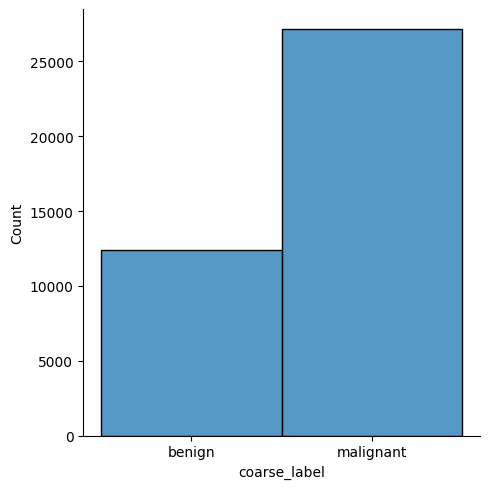

In [10]:
sns.displot(data=folds,x='coarse_label')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


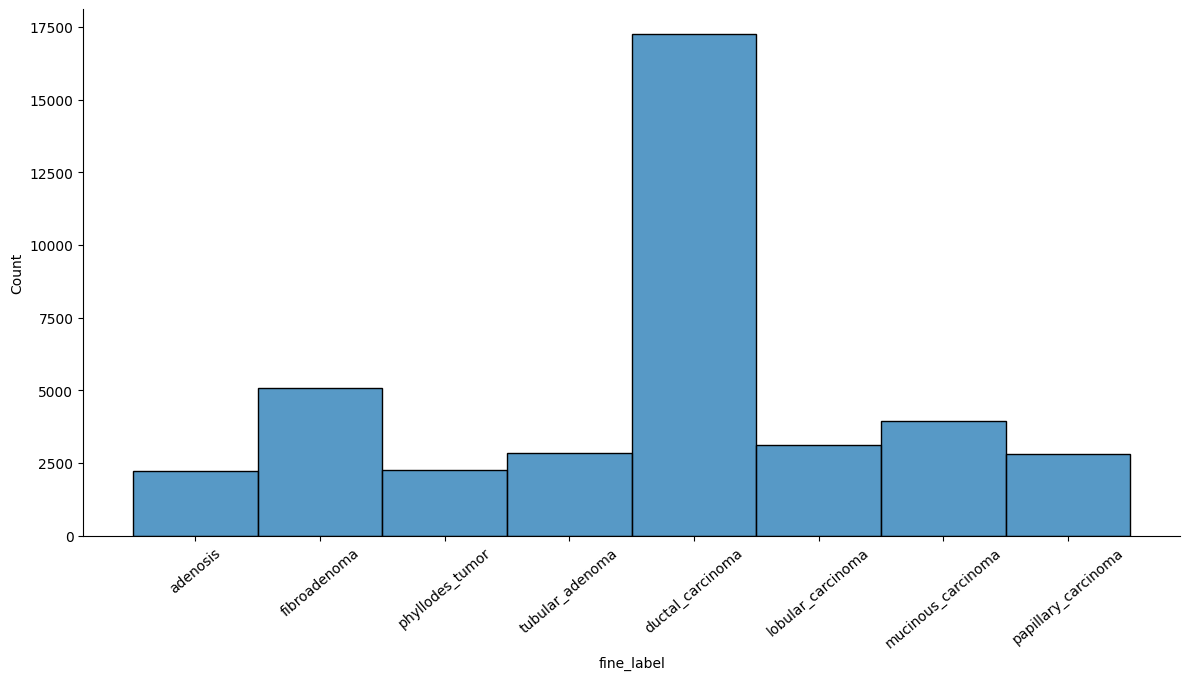

In [11]:
sns.displot(data=folds, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [12]:
test_df = folds.groupby('fine_label', group_keys=False).sample(n=850, random_state=SEED)
train_valid_df = folds.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

valid_df = train_valid_df.groupby('fine_label', group_keys=False).sample(frac=0.25, random_state=SEED)
train_df = train_valid_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Training Set: ')
print(train_df['fine_label'].value_counts())
print('Total Count: ', train_df.shape[0])

print('Validation Set:')
print(valid_df['fine_label'].value_counts())
print('Total Count: ', valid_df.shape[0])

print('Test Set:')
print(test_df['fine_label'].value_counts())
print('Total Count: ', test_df.shape[0])

Training Set: 
fine_label
ductal_carcinoma       12304
fibroadenoma            3165
mucinous_carcinoma      2332
lobular_carcinoma       1710
tubular_adenoma         1496
papillary_carcinoma     1462
phyllodes_tumor         1061
adenosis                1028
Name: count, dtype: int64
Total Count:  24558
Validation Set:
fine_label
ductal_carcinoma       4101
fibroadenoma           1055
mucinous_carcinoma      778
lobular_carcinoma       570
tubular_adenoma         499
papillary_carcinoma     488
phyllodes_tumor         354
adenosis                342
Name: count, dtype: int64
Total Count:  8187
Test Set:
fine_label
adenosis               850
ductal_carcinoma       850
fibroadenoma           850
lobular_carcinoma      850
mucinous_carcinoma     850
papillary_carcinoma    850
phyllodes_tumor        850
tubular_adenoma        850
Name: count, dtype: int64
Total Count:  6800


     Train  Validation  Test
mag                         
40    6081        2091  1803
100   6510        2140  1755
200   6281        2087  1697
400   5686        1869  1545


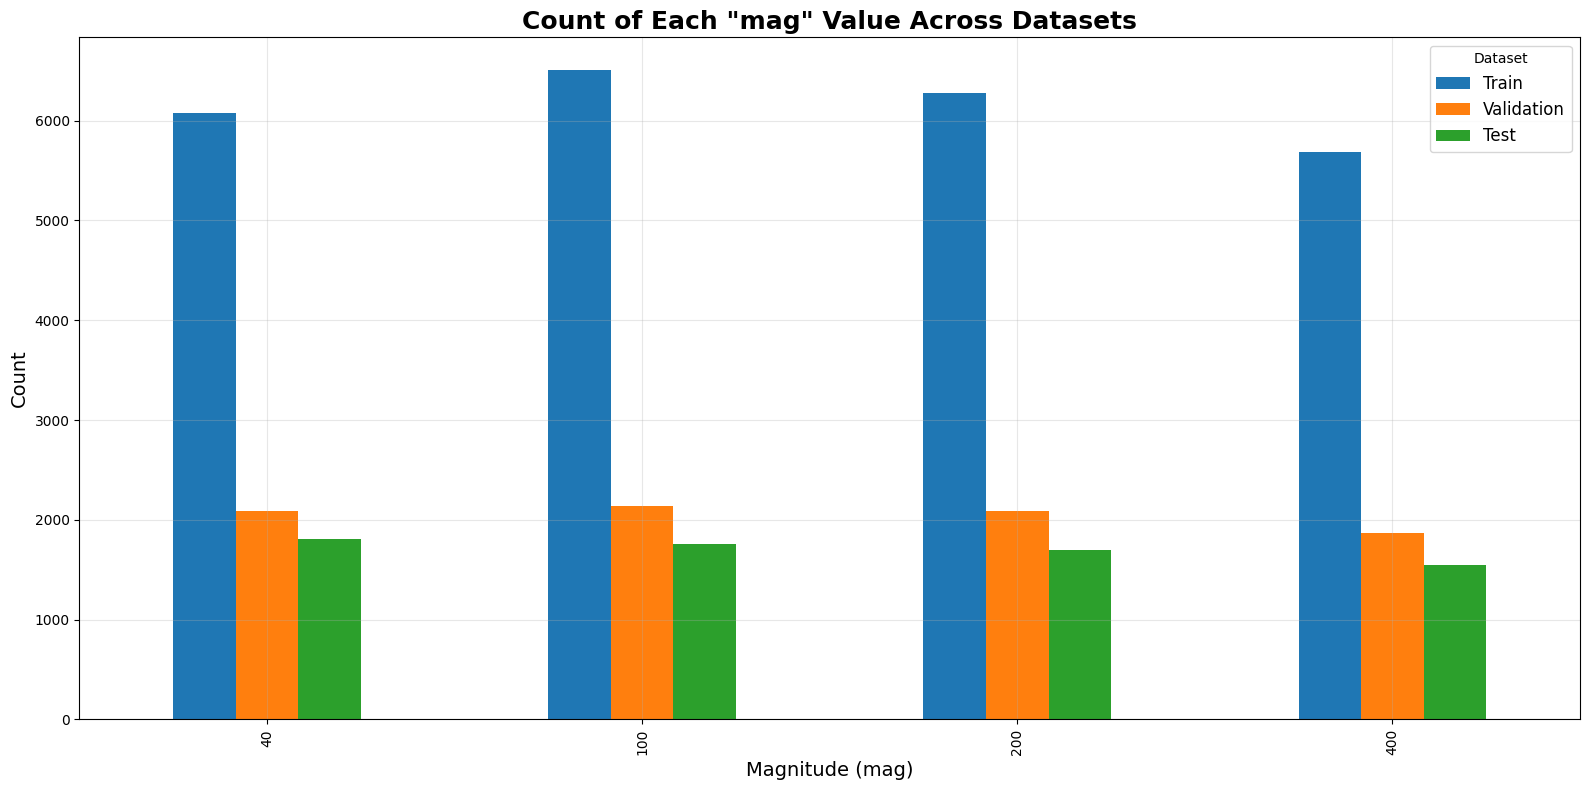

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Count occurrences of each mag per dataset
train_counts = train_df['mag'].value_counts().sort_index()
valid_counts = valid_df['mag'].value_counts().sort_index()
test_counts  = test_df['mag'].value_counts().sort_index()

# Combine into one DataFrame for comparison
mag_counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
}).fillna(0).astype(int)

# Display table (optional)
print(mag_counts_df.head())

# Plot side-by-side bars
mag_counts_df.plot(kind='bar', figsize=(16, 8))
plt.title('Count of Each "mag" Value Across Datasets', fontsize=18, fontweight='bold')
plt.xlabel('Magnitude (mag)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Dataset', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


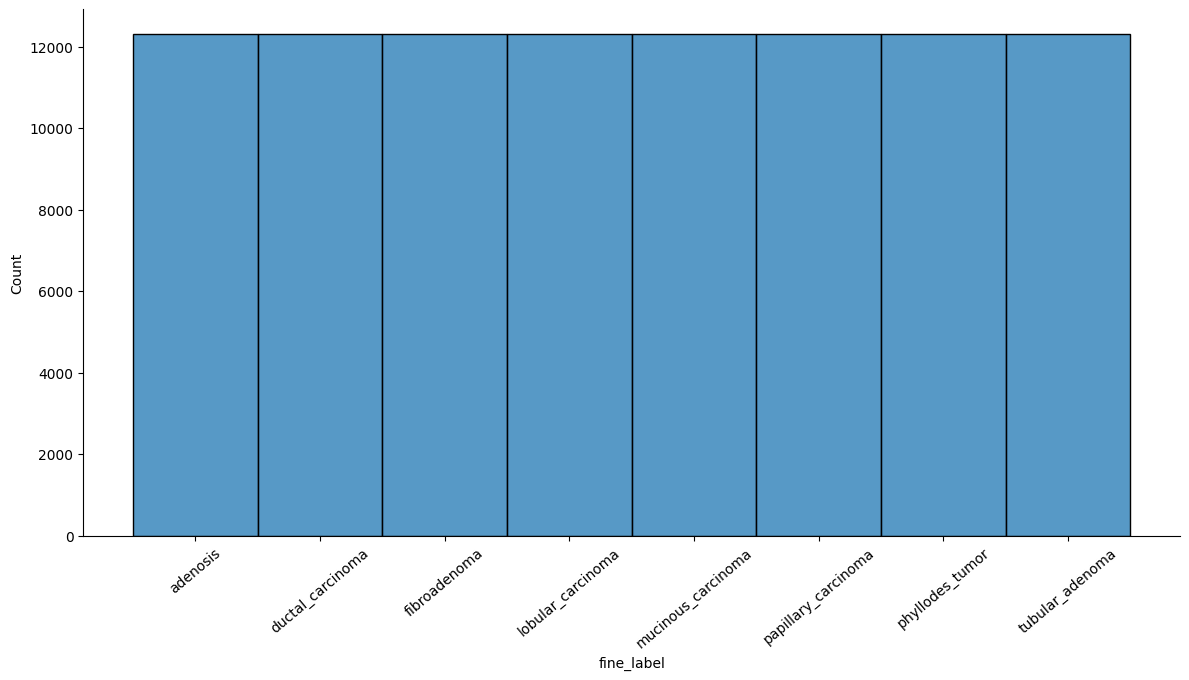

In [14]:
#upsampling
max_count = np.max(train_df.fine_label.value_counts())
min_count = np.min(train_df.fine_label.value_counts())
train_df = train_df.groupby('fine_label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.fine_label.value_counts()

sns.displot(data=train_df, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.2,1.0]
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# train_subset = train_df.sample(frac=0.1, random_state=42)
# val_subset = valid_df.sample(frac=0.1, random_state=42)

# train_generator = train_datagen.flow_from_dataframe(
#     train_subset,
#     x_col='filename',
#     y_col='fine_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_dataframe(
#     val_subset,
#     x_col='filename',
#     y_col='fine_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

Found 98432 validated image filenames belonging to 8 classes.
Found 8187 validated image filenames belonging to 8 classes.
Found 6800 validated image filenames belonging to 8 classes.


In [17]:
print(train_generator.image_shape)
print(val_generator.image_shape)
print(test_generator.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


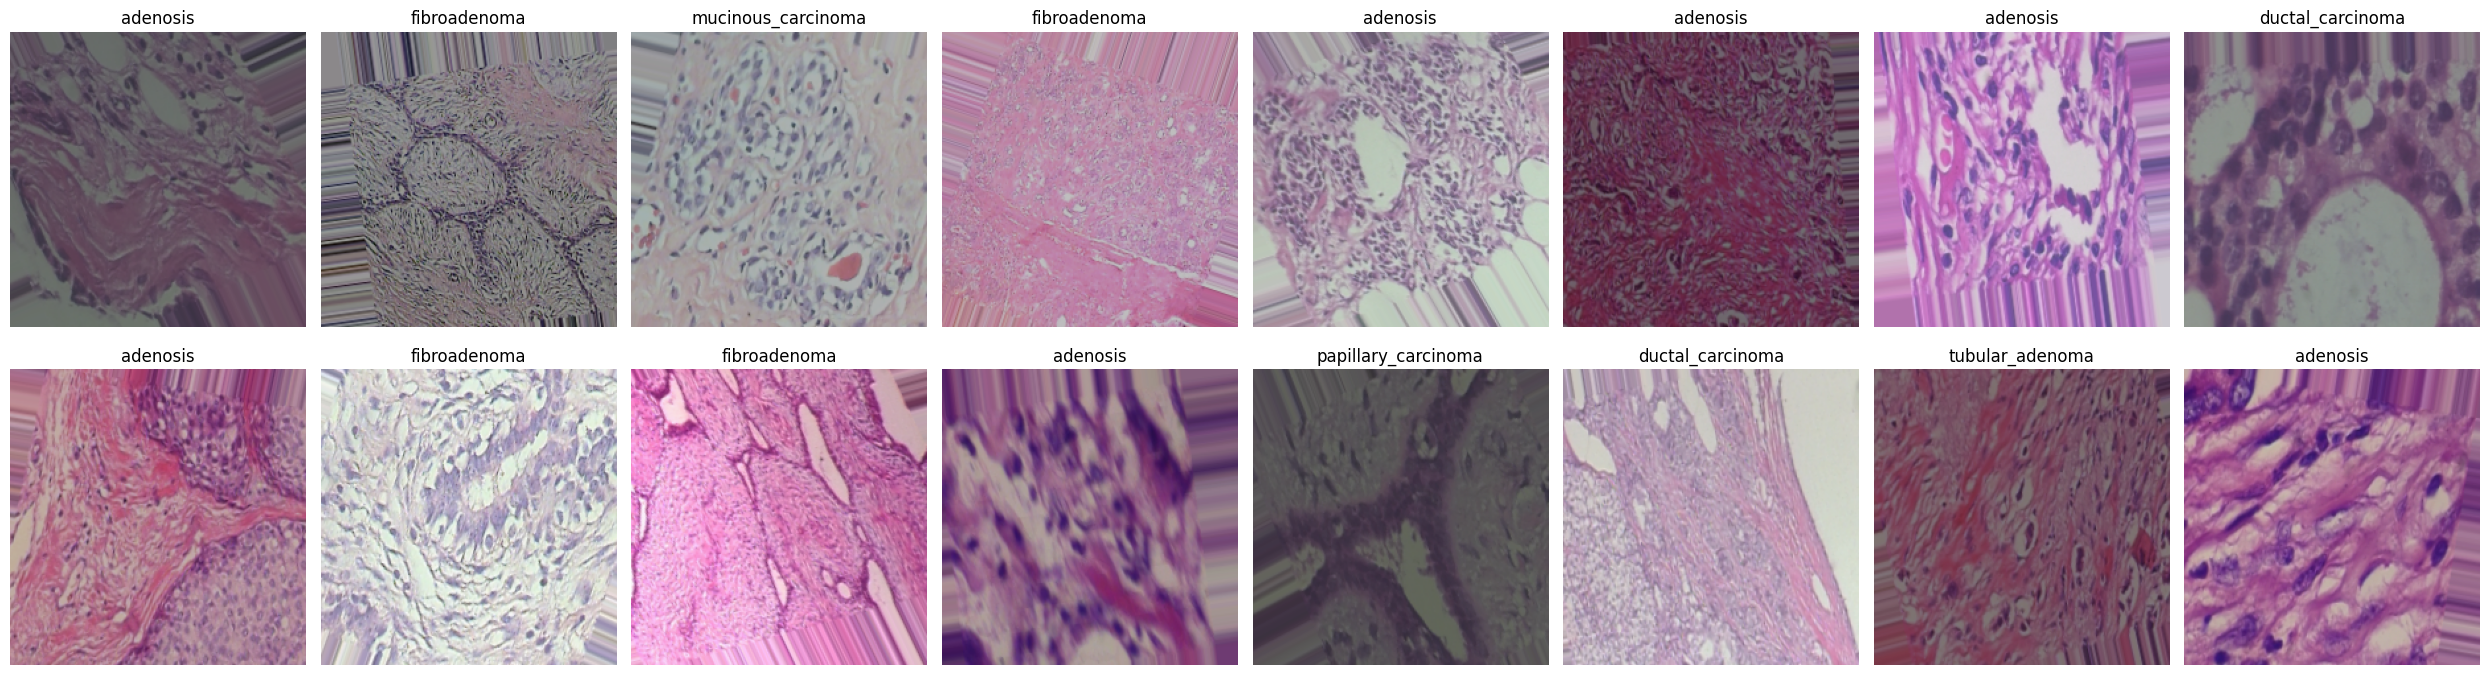

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma','ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def view_image(generator, col=8, row=2, size=(25, 7)):
    images, labels = next(generator)
    total = len(images)
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)

    for i in range(total):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


view_image(train_generator)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

def triple_attention(a, b, proj_channels=None, reduction=8, name=None):
    """
    a, b: tensors (B, H, W, C_a) and (B, H2, W2, C_b)
    Returns: tensor shaped like `a` (B, H, W, C_a) after combining channel, spatial, cross-attn.
    """

    # -------- channel attention (on a) ----------
    def channel_attention(x):
        ch = int(x.shape[-1])
        avg = layers.GlobalAveragePooling2D()(x)               # (B, C)
        dense1 = layers.Dense(max(ch // reduction, 4), activation='relu')(avg)
        dense2 = layers.Dense(ch, activation='sigmoid')(dense1)
        scale = layers.Reshape((1, 1, ch))(dense2)
        return layers.Multiply()([x, scale])

    # -------- spatial attention (on a) ----------
    def spatial_attention(x):
        avg_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
        max_pool = layers.Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])  # (B,H,W,2)
        attn = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
        return layers.Multiply()([x, attn])

    # -------- cross attention (a attends to b) ----------
    def cross_attention(a, b,proj_dim=64):
        """
        a: (B, 14,14,480)
        b: (B, 14,14,480)
        """
    
        # small projection to reduce compute
        q = layers.Conv2D(proj_dim, 1, padding='same', name=f"{name}_q")(a)
        k = layers.Conv2D(proj_dim, 1, padding='same', name=f"{name}_k")(b)
        v = layers.Conv2D(proj_dim, 1, padding='same', name=f"{name}_v")(b)
    
        # flatten spatial dims: (B,196,C)
        flatten = lambda x: tf.reshape(x, (tf.shape(x)[0], -1, tf.shape(x)[-1]))
        qf = layers.Lambda(flatten)(q)
        kf = layers.Lambda(flatten)(k)
        vf = layers.Lambda(flatten)(v)
    
        # scaled dot-product attention
        scale = tf.math.sqrt(tf.cast(proj_dim, tf.float32))
        logits = layers.Lambda(lambda t: tf.matmul(t[0], t[1], transpose_b=True) / scale)([qf, kf])
        attn = layers.Activation("softmax")(logits)
    
        out = layers.Lambda(lambda t: tf.matmul(t[0], t[1]))([attn, vf])  # (B,196,C)
    
        # unflatten back to (14×14×C)
        unflatten = lambda x: tf.reshape(x, (tf.shape(x)[0], 14, 14, proj_dim))
        out = layers.Lambda(unflatten)(out)
    
        # project back to original channels (480)
        out_proj = layers.Conv2D(a.shape[-1], 1, padding='same', name=f"{name}_proj")(out)
    
        # residual connection
        return layers.Add()([a, out_proj])


    # apply the three attentions
    ca = channel_attention(a)
    sa = spatial_attention(a)
    xa = cross_attention(a, b)

    # combine (you can sum or concatenate; sum keeps dims stable)
    out = layers.Add()([ca, sa, xa])
    out = layers.Activation('gelu')(out)
    return out

In [20]:
def freeze_and_inspect(base_model, freeze_until=150, branch_name="Branch"):
    # Freeze layers
    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    for layer in base_model.layers[freeze_until:]:
        layer.trainable = True

    for layer in base_model.layers:
      if isinstance(layer, layers.BatchNormalization):
          layer.trainable = True
      else:
          continue

In [21]:
class WeightedFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # single scalar weight in (0,1) via sigmoid on unconstrained variable
        self.w_raw = self.add_weight(shape=(1,), initializer="zeros", trainable=True, name="w_raw")
        super().build(input_shape)

    def call(self, inputs):
        f1, f2 = inputs
        alpha = tf.sigmoid(self.w_raw)  # in (0,1)
        return alpha * f1 + (1.0 - alpha) * f2

In [22]:
from tensorflow.keras import optimizers
from keras import Sequential, Model, backend as K
from keras.layers import Dense, Input , Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0,DenseNet121


def build_dual_branch_model(input_shape=(224,224,3), num_classes=8, lambda_sim=0.1, proj_dim=512):
    inputs = layers.Input(shape=input_shape)

    # --- Branch 1: EfficientNet ---
    base1 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    freeze_and_inspect(base1, freeze_until=80, branch_name="EffNetB0_Branch1")
    mid1 = base1.get_layer("block4c_activation").output  
    out1 = base1.output
    branch1_model = models.Model(base1.input, [mid1, out1], name="EffNetB0_Branch1")
    mid1_map, f1_map = branch1_model(inputs)

    # --- Branch 2: DenseNet ---
    base2 = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    freeze_and_inspect(base2, freeze_until=80, branch_name="DenseNet_Branch")
    mid2 = base2.get_layer("conv4_block7_concat").output
    out2 = base2.output
    branch2_model = models.Model(base2.input, [mid2, out2], name="DenseNet_Branch2")
    mid2_map, f2_map = branch2_model(inputs)

    # --- Triple Attention on mids ---
    ta_mid1 = triple_attention(mid1_map, mid2_map,name="mid1_to_mid2")
    ta_mid2 = triple_attention(mid2_map, mid1_map,name="mid2_to_mid1")

    mid_fused = layers.Concatenate()([
        GlobalAveragePooling2D()(ta_mid1),
        GlobalAveragePooling2D()(ta_mid2)
    ])

    # --- High-level pooled vectors (different sizes originally) ---
    f1 = GlobalAveragePooling2D()(f1_map)   # -> (None, 1280) for EffNetB0
    f2 = GlobalAveragePooling2D()(f2_map)   # -> (None, 1024) for DenseNet121

    # --- Project both to same dimension proj_dim (important!) ---
    proj_f1 = Dense(proj_dim, activation=None, name="proj_f1")(f1)
    proj_f1 = BatchNormalization(name="proj_f1_bn")(proj_f1)
    proj_f1 = layers.Activation("gelu", name="proj_f1_act")(proj_f1)

    proj_f2 = Dense(proj_dim, activation=None, name="proj_f2")(f2)
    proj_f2 = BatchNormalization(name="proj_f2_bn")(proj_f2)
    proj_f2 = layers.Activation("gelu", name="proj_f2_act")(proj_f2)

    # --- Weighted fusion of high-level projected vectors ---
    fused_high = WeightedFusion(name="highlevel_weighted_fusion")([proj_f1, proj_f2])

    # --- Final fusion and head ---
    fused = layers.Concatenate()([mid_fused, fused_high])
    fused = Dense(512, activation='gelu')(fused)
    fused = BatchNormalization()(fused)
    fused = layers.Dropout(0.4)(fused)

    fused = Dense(256, activation='gelu')(fused)
    fused = BatchNormalization()(fused)
    fused = layers.Dropout(0.3)(fused)

    outputs = Dense(num_classes, activation='softmax')(fused)

    model = models.Model(inputs, outputs, name='EffNet_DenseNet_DualBranch_proj')
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

In [23]:
tf.keras.backend.clear_session()
model = build_dual_branch_model()
model.summary()

I0000 00:00:1763411317.114460      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763411317.115149      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EffNet_DenseNet_DualBranch_proj"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EffNetB0_Branch1    │ [(None, 14, 14,   │  4,049,571 │ input_layer[0][0] │
│ (Functional)        │ 480), (None, 7,   │            │                   │
│                     │ 7, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DenseNet_Branch2    │ [(None, 14, 14,   │  7,037,504 │ input_layer[0][0] │
│ (Functional)        │ 480), (None, 7,   │            │                   │
│                     │ 7, 1024)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid1_to_mid2_q      │ (None, 14, 14,    │     30,784 │ EffNetB0_Branch1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid1_to_mid2_k      │ (None, 14, 14,    │     30,784 │ DenseNet_Branch2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid2_to_mid1_q      │ (None, 14, 14,    │     30,784 │ DenseNet_Branch2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid2_to_mid1_k      │ (None, 14, 14,    │     30,784 │ EffNetB0_Branch1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 64)  │          0 │ mid1_to_mid2_q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 64)  │          0 │ mid1_to_mid2_k[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, None, 64)  │          0 │ mid2_to_mid1_q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, None, 64)  │          0 │ mid2_to_mid1_k[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, None,      │          0 │ lambda_2[0][0],   │
│                     │ None)             │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid1_to_mid2_v      │ (None, 14, 14,    │     30,784 │ DenseNet_Branch2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, None,      │          0 │ lambda_10[0][0],  │
│                     │ None)             │            │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid2_to_mid1_v      │ (None, 14, 14,    │     30,784 │ EffNetB0_Branch1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 480)       │          0 │ EffNetB0_Branch1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ lambda_5[0][0]    │
│ (Activation)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,526,058 (51.60 MB)

 Trainable params: 12,712,865 (48.50 MB)

 Non-trainable params: 813,193 (3.10 MB)

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    '/kaggle/working/efficientnet_plus_densenet_on_Breakhis_multiclass_model_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      
    factor=0.5,              
    patience=4,              
    verbose=1,               
    min_lr=1e-7              
)

csv_logger = CSVLogger('training_log.csv', append=False)

In [25]:
model.load_weights('/kaggle/input/effnet-densenet-epoch1/keras/default/1/efficientnet_plus_densenet_on_Breakhis_multiclass_model_epoch_01_valacc_0.7729.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=14,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint,reduce_lr,early_stop,csv_logger]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/14


I0000 00:00:1763411418.661417      65 service.cc:148] XLA service 0x7f6964049360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763411418.662573      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763411418.662595      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763411432.704347      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1763411455.758530      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763411455.897977      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763411456.226366      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

6152/6152 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8638 - auc: 0.9874 - loss: 0.3848 - precision: 0.8843 - recall: 0.8447
Epoch 1: val_accuracy improved from -inf to 0.87126, saving model to /kaggle/working/efficientnet_plus_densenet_on_Breakhis_multiclass_model_epoch_01_valacc_0.8713.weights.h5
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 2691s 400ms/step - accuracy: 0.8638 - auc: 0.9874 - loss: 0.3848 - precision: 0.8843 - recall: 0.8447 - val_accuracy: 0.8713 - val_auc: 0.9867 - val_loss: 0.3721 - val_precision: 0.8782 - val_recall: 0.8658 - learning_rate: 0.0010
Epoch 2/14
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9103 - auc: 0.9938 - loss: 0.2570 - precision: 0.9210 - recall: 0.9014
Epoch 2: val_accuracy did not improve from 0.87126
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 2379s 387ms/step - accuracy: 0.9103 - auc: 0.9938 - loss: 0.2570 - precision: 0.9210 - recall: 0.9014 - val_accuracy: 0.7773 - val_auc: 0.9713 - val_loss: 0.6695 - val_precision: 0.7913 - val_recall: 0.7606 - l

In [27]:
loss, accuracy,auc,precision,recall = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")

425/425 ━━━━━━━━━━━━━━━━━━━━ 86s 201ms/step - accuracy: 0.9784 - auc: 0.9988 - loss: 0.0685 - precision: 0.9794 - recall: 0.9779
Test Loss: 0.0675
Test Accuracy: 98.12%
Test Precision: 98.03%
Test Recall: 99.84%


In [28]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

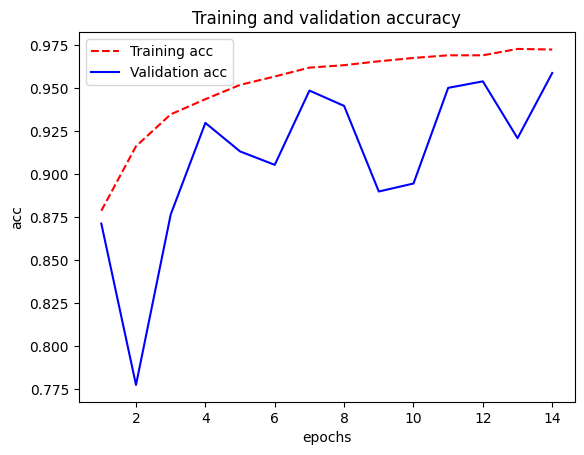

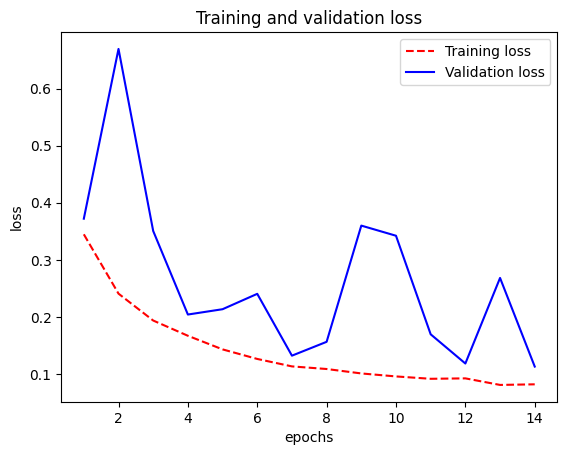

<Figure size 640x480 with 0 Axes>

In [29]:
plot_history(history)

425/425 ━━━━━━━━━━━━━━━━━━━━ 99s 193ms/step


<Figure size 800x800 with 0 Axes>

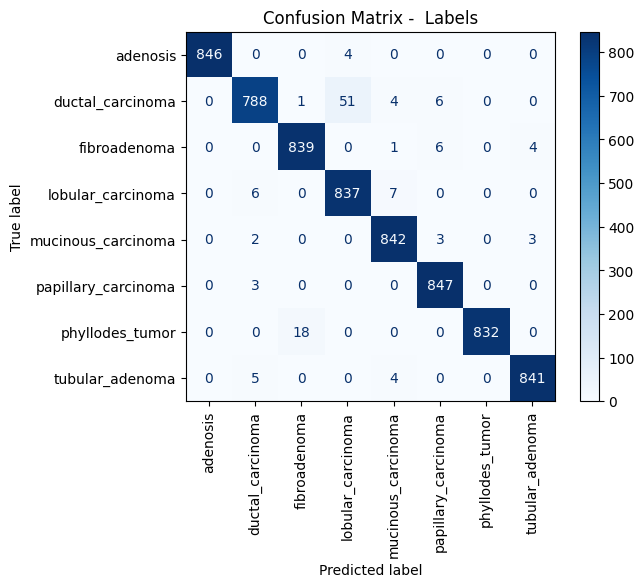

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Predict labels for test set
# -------------------------------
y_pred_probs = model.predict(test_generator)       # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)           # predicted class indices
y_true = test_generator.classes                    # true class indices

# -------------------------------
# 2. Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

# -------------------------------
# 3. Display confusion matrix
# -------------------------------
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_generator.class_indices.keys())
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix -  Labels")
plt.show()

In [31]:
df = pd.DataFrame(history.history)
df['epoch'] = range(1, len(df) + 1)

df.to_csv('training_history.csv', index=False)